In [6]:
!pip install gensim 

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 33.5 MB/s eta 0:00:00a 0:00:01
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 32.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# from google.colab import drive
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

#from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from gensim.models import KeyedVectors
# import gensim.downloader as api
import random
import os
from gensim.models import Word2Vec


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pedrosantos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
#VSCODE
train_df = pd.read_csv(r"/Users/pedrosantos/Documents 2/Text Mining/Data/train.csv")
test_df = pd.read_csv(r"/Users/pedrosantos/Documents 2/Text Mining/Data/test.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text"], train_df["label"], test_size=0.2, stratify=train_df["label"], random_state=42)

In [4]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def full_preprocess(text):
    # ─── STEP 1: BASIC CLEANING ───
    text = re.sub(r"http\S+|www\S+", "<URL>", text)          # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)                   # Replace mentions
    text = re.sub(r"#", "", text)                            # Remove hashtag symbol
    text = re.sub(r"[^\w\s]", " ", text)                 # Remove punctuation selectively
    text = text.lower()                                      # Lowercase
    text = re.sub(r"\s+", " ", text).strip()                 # Normalize spaces

    # ─── STEP 2: TOKENIZATION ───
    tokens = nltk.word_tokenize(text)

    # ─── STEP 3: REMOVE STOPWORDS ───
    tokens = [word for word in tokens if word not in stop_words]

    # ─── STEP 4: LEMMATIZATION ───
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # ─── STEP 5: STEMMING ───
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [5]:
X_train_tokens = X_train.apply(full_preprocess)
X_test_tokens = X_test.apply(full_preprocess)

<hr>

# Word2Vec + CNN + BiLSTM

In [7]:
word2vec = Word2Vec(
    sentences = X_train_tokens,
    vector_size = 200,
    window = 3,
    min_count=1,
    workers = 8,
    sg=1,
    epochs=15,
    seed=42,
    negative=5
)

In [9]:
X_train_vec = X_train_tokens.apply(lambda x: [word2vec.wv[word] for word in x if word in word2vec.wv])
X_test_vec = X_test_tokens.apply(lambda x: [word2vec.wv[word] for word in x if word in word2vec.wv])

In [10]:
# Set maxlen same as before or based on training data
maxlen = 33
embedding_dim = 200

def pad_tweet_vector(tweet_vec, maxlen, dim):
    if len(tweet_vec) >= maxlen:
        return tweet_vec[:maxlen]
    else:
        return tweet_vec + [np.zeros(dim)] * (maxlen - len(tweet_vec))

X_train_pad = np.array([pad_tweet_vector(v, maxlen, embedding_dim) for v in X_train_vec])
X_test_pad = np.array([pad_tweet_vector(v, maxlen, embedding_dim) for v in X_test_vec])

In [11]:
X_train_pad.shape

(7634, 33, 200)

In [32]:
input_layer = Input(shape=(maxlen, embedding_dim))


# ─── CNN Block ───
conv1 = Conv1D(128, 2, padding='valid', activation='relu')(input_layer)
conv1 = BatchNormalization()(conv1)
conv2 = Conv1D(256, 2, padding='valid', activation='relu')(conv1)
conv2 = GlobalMaxPooling1D()(conv2)

# ─── BiLSTM Block ───
bilstm1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15))(input_layer)
bilstm2 = Bidirectional(LSTM(64, return_sequences=False, dropout=0.15))(bilstm1)

# ─── Merge CNN + LSTM ───
merged = concatenate([conv2, bilstm2])
drop = Dropout(0.45)(merged)

output_layer = Dense(3, activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 33, 200)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 32, 128)   │     51,328 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 31, 256)   │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 33, 256)   │    336,896 │ input_layer_9[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_16[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 128)       │    164,352 │ bidirectional_14… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 384)       │          0 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │      1,155 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 620,035 (2.37 MB)

 Trainable params: 619,779 (2.36 MB)

 Non-trainable params: 256 (1.00 KB)

In [33]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=45,
    batch_size=32
)

Epoch 1/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.3469 - loss: 2.0563 - val_accuracy: 0.6475 - val_loss: 0.9137
Epoch 2/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.5375 - loss: 1.4548 - val_accuracy: 0.6595 - val_loss: 0.8411
Epoch 3/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.5597 - loss: 1.3706 - val_accuracy: 0.6710 - val_loss: 0.8477
Epoch 4/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.5775 - loss: 1.2793 - val_accuracy: 0.6799 - val_loss: 0.8444
Epoch 5/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5844 - loss: 1.2192 - val_accuracy: 0.6826 - val_loss: 0.8292
Epoch 6/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.6167 - loss: 1.1168 - val_accuracy: 0.6909 - val_loss: 0.8005
Epoch 7/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.6174 - loss: 1.0993 - val_accuracy: 0.6936 - val_loss: 0.7870
Epoch 8/45
239/239 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6188 - loss: 1.0878 - 

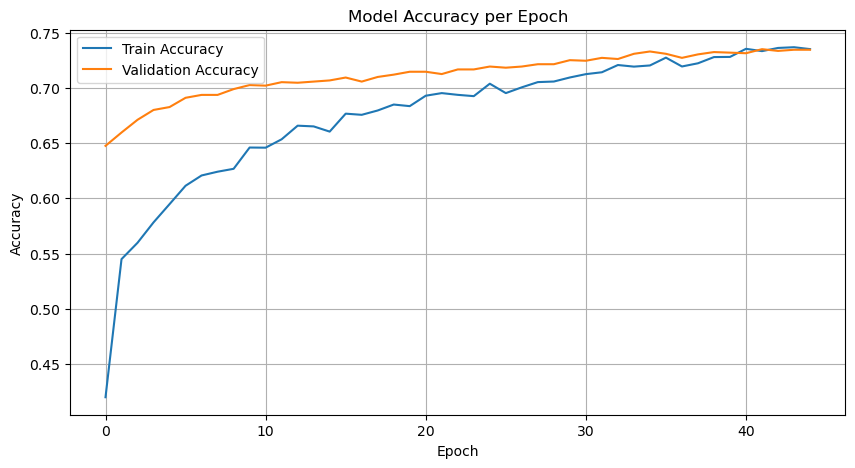

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()